Мы рассмотрим данные одной мобильной игры "Cookie cats" - это стандартная игра "три в ряд", где игроку нужно соединять элементы одинакового цвета, чтобы очистить поле. И там есть поющие коты...
Есть одно ограничение в игре, которое заключается в том, что рано или поздно при прохождении игры возникают ворота, которые блокируют прохождение уровней. Изначально эти ворота стояли на 30 уровне, но мы будем анализировать А/Б - тест, в котором разработчики передвинули ворота на 40 уровень. Мы будем оценивать влияение этого изменения на retention (удержание), т.е. отношение уникальных игроков, зашедших в игру нв 1, 2, ..., N день после установки ко всем игрокам, установившим игру в этот день.



# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/cookie_cats.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
df.shape

(90189, 5)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


В данных содержится информация по 90 189 игроков, которые установили игру в течение периода AB-тестирования. К переменным относятся:

**userid:** уникальный идентификатор для каждого игрока.

**version:** Указывает, был ли игрок в контрольной группе (gate_30 - ворота на уровне 30) или в тестовой группе (gate_40 - ворота на уровне 40).

**sum_gamerounds:** Количество игровых раундов, сыгранных игроком в течение первой недели после установки.

**retention_1**: Бинарная переменная, указывающая, вернулся ли игрок, чтобы играть в игру через день после установки.

**retention_7:** Бинарная переменная, указывающая, вернулся ли игрок, чтобы играть в игру через семь дней после установки.

Игроки были случайным образом распределены как на gate_30, либо на gate_40 при установке.

In [ ]:
df.groupby("version")["userid"].count()

,userid
version,
gate_30,44700
gate_40,45489


Игроков примерно одинаковое количество в каждой группе.

# Распределение числа игровых сессий

Посчитаем количество игроков, оставшихся в игре для каждого уровня.

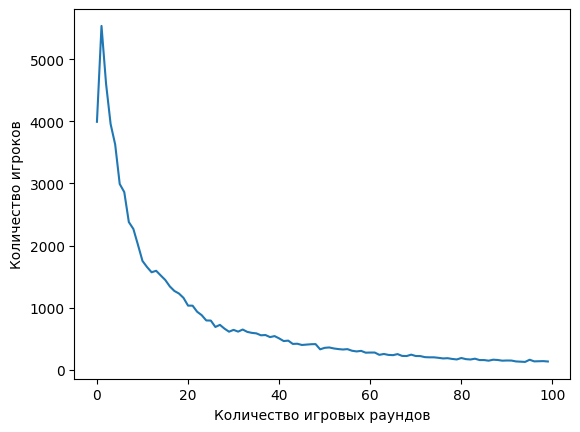

In [ ]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()
ax = plot_df.head(100).plot()
ax.set_xlabel("Количество игровых раундов")
ax.set_ylabel("Количество игроков");

На графике видим, что большое количество игроков скачало, но не начало играть. Также по графику, можно заметить, что не многие игроки втянулись сильно в игру, ближе к 100 раундов график стремиться к нулю.
Важно, чтобы игроки возвращались вновь и вновь. Чтобы измерить насколько игра захватывающая используют метрику удержания первого дня - процент тех, кто вернулся спустя 1 день после установки.

# Удержание первого дня

Рассмотрим средние.

In [16]:
df.retention_1.mean()

np.float64(0.4452095044850259)

In [18]:
df.groupby("version")["retention_1"].mean()

,retention_1
version,
gate_30,0.448188
gate_40,0.442283


Удержание первого дня немного меньше после изменения уровня блокировки. Нужно проверить значимость этого эффекта, для этого будем использовать тест о равенстве долей

In [19]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05 # уровень значимости

df_agg = df.groupby("version")["retention_1"].agg(["count", "sum", "mean"])

n_obs = df_agg['count'].values # размер выборок
m_obs = df_agg['sum'].values   # число успехов
p_obs = df_agg['mean'].values  # доли

z_obs, p_val = proportions_ztest(m_obs, n_obs, value=0, alternative='larger')
print(f"Наблюдаемое значение статистики: {z_obs:.3}")
print(f"p-значение: {p_val:.3}")

Наблюдаемое значение статистики: 1.78
p-значение: 0.0372


Гипотеза о равенстве долей может быть отвергнута с 5% уровнем значимости.

Проведем оценку мощности этого эксперимента.

In [31]:
n_30, n_40 = n_obs # размеры выборок
p_30, p_40 = p_obs # доли

# дисперсии
var_40, var_30 = p_40 *(1-p_40), p_30*(1-p_30)

# стандартный размер эффекта
effect = 2 * np.arcsin(np.sqrt(p_30)) - 2 * np.arcsin(np.sqrt(p_40))
effect

np.float64(0.011881898259223478)

In [32]:
from statsmodels.stats.power import zt_ind_solve_power

zt_ind_solve_power(effect_size=effect, nobs1=sum(n_obs), alpha=0.05, power=None, ratio=n_obs[1]/n_obs[0], alternative='larger')

np.float64(0.8130886024781628)

# Удержание седьмого дня

Эта метрика особенно интересна, так как показывает сколько людей остаются на долгосрочной основе и на 7 день уже больше людей пройдут игру до 40-го уровня, что важно для нашего теста.

In [33]:
df.groupby("version")['retention_7'].mean()

,retention_7
version,
gate_30,0.190201
gate_40,0.182000


Как и с удержанием первого дня, можем заметить, что удержание 7 дня немного ниже, когда ворота находятся на 40-м уровне и эта разница выше, чем при удержании 1 дня. И также можем заметить, что удержание 7 дня ниже, чем удержание 1 дня, спустя неделю количество пользователей, которые заходят в игру существенно сократилось.

Нужно проверить существена ли разница.

In [34]:
from statsmodels.stats.proportion import proportions_ztest

alpha = 0.05 # уровень значимости

df_agg = df.groupby("version")["retention_7"].agg(["count", "sum", "mean"])

n_obs = df_agg['count'].values # размер выборок
m_obs = df_agg['sum'].values   # число успехов
p_obs = df_agg['mean'].values  # доли

z_obs, p_val = proportions_ztest(m_obs, n_obs, value=0, alternative='larger')
print(f"Наблюдаемое значение статистики: {z_obs:.3}")
print(f"p-значение: {p_val:.3}")

Наблюдаемое значение статистики: 3.16
p-значение: 0.000777


Видим, что разница сильно значима. Т.е. на недельном диапазоне произойдет достаточно большой отток пользователей.

# Выводы

Результаты АБ-теста говорят нам о том, что в группе с воротами на 30-м уровне удержание на 7 день значительно превышает эту же метрику в группе с воротами на 40-м уровне. Значит, не нужно сдвигать ворота на 40-й уровень, если мы хотим поддерживать удержание на высоком уровне.
Возможно, такой эффект наблюдается из-за гедонистической адаптации, т.е. игроки успевают наиграться и заскучать к 40-му уровню и препятствие отбивает у них желание проходить игру дальше, в то время, когда эти ворота на 30-м уровне и пользователь еще не насытился игрой к этому времени, то ему хочется продолжать играть.